# Advanced Data Analysis


This group project will focus on analysing data on flights in the US.

Unless otherwise specified, the problems can be solved using either Spark or Pandas.

Some useful links:

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)


## Colab setup

The following cell will install Spark, if the notebook is running on COLAB. Before running this cell, you should access the following link [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing)

In [ ]:
#Run this cell to install Spark on Colab
import os

if 'COLAB_GPU' in os.environ : 
    !apt-get install openjdk-8-jdk-headless
    !pip install pyspark==3.1.2
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.2-spark3.1-s_2.12.jar pyspark-shell'

    from google.colab import drive
    drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk-headless is already the newest version (8u292-b10-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
--2021-12-08 20:27:34--  https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 13.32.87.119, 13.32.87.68, 13.32.87.12, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|13.32.87.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247882 (242K) [binary/octet-stream]
Saving to: ‘graphframes-0.8.2-spark3.1-s_2.12.jar.6’

graphframes-0.8.2-s 100%[===================>] 242.07K  --.-KB/s    in 0.06s   

2021-12-08 20:27:34 (3.96 MB/s) - ‘graphframes-0.8.2-spark3.1-s_2.12.jar.6’ saved [247882/247882]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.m

## Local setup

For running the group project locally, you should create a directory named **data** in the directory where you have this notebook. Then, you should download to the **data** directory of the repository.

## Initialization

Import libraries. 

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors

plt.style.use('seaborn')

print(pyspark.__version__)


3.1.2


Let's start spark session and set *log* level to ERROR.

In [ ]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Group project") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

if 'COLAB_GPU' in os.environ : 
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.1-s_2.12.jar')
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETED
    ;
else:
    spark.sparkContext.addPyFile('/usr/local/spark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar')


spark.sparkContext.setLogLevel("ERROR")

## Data selection

This cell controls the dataset you will be using. Note that this cell will control the path to the files, dependening on the platform you are using to run the code.

The sample.csv file is available at https://drive.google.com/file/d/1H6uZ4Y-0WNfavUdqOLhVB9Bg8YPUIwyp/view?usp=sharing
DISCLAIMER: Code need to be changed according to the new repository structure.

In [ ]:
# Comment the following 
flightsF = "sample.csv"
#flightsF = "complete.csv"
#flightsF = "data-2009.csv"
#flightsF = "data-2010.csv"
#flightsF = "data-2011.csv"
#flightsF = "data-2012.csv"
#flightsF = "data-2013.csv"
#flightsF = "data-2014.csv"
#flightsF = "data-2015.csv"
#flightsF = "data-2016.csv"
#flightsF = "data-2017.csv"
#flightsF = "data-2018.csv"

if 'COLAB_GPU' in os.environ : 
    FLIGHTS_FILENAME = "/content/drive/MyDrive/group2122/" + flightsF
    AIRPORTS_FILENAME = "/content/drive/MyDrive/group2122/airports.csv"
    HOLIDAYS_FILENAME = "/content/drive/MyDrive/group2122/holidays.csv"
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    FLIGHTS_FILENAME = os.path.join( "data", flightsF)
    AIRPORTS_FILENAME = os.path.join( "data", "airports.csv")
    HOLIDAYS_FILENAME = os.path.join( "data", "holidays.csv")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Datasets

This section describes the datasets you have available for your analysis.

### Flights

The flights dataset, generated from data available at [https://www.transtats.bts.gov/DataIndex.asp](https://www.transtats.bts.gov/DataIndex.asp), includes the following columns:

* FL_DATE: date of the flight (format: yyyy-mm-dd)
* OP_CARRIER: carrier code
* OP_CARRIER_FL_NUM: carrier flight number
* ORIGIN: origin airport (using IATA codes)
* DEST: destination airport (using IATA codes)
* CRS_DEP_TIME: scheduled local departure time (format for all times: hh:mm)
* DEP_TIME: actual departure time
* DEP_DELAY: departure delay, in minutes
* TAXI_OUT: taxi out time
* WHEELS_OFF: actual local wheel off time
* WHEELS_ON: actual local wheel on time
* TAXI_IN: actual local taxi in time
* CRS_ARR_TIME: scheduled local arrival time
* ARR_TIME: actual arrival time
* ARR_DELAY: arrival delay, in minutes
* CANCELLED: 1 if the flight has been cancelled; 0 otherwise
* CANCELLATION_CODE: code of cancelation (A = carrier, B = weather, C = NAS, D = security)
* DIVERTED: 1 if the flight has been diverted; 0 otherwise
* CRS_ELAPSED_TIME: estimated elapsed time
* ACTUAL_ELAPSED_TIME: actual elapsed time
* AIR_TIME: flight time, in minutes
* DISTANCE: flight distance, in miles
* CARRIER_DELAY: delay due to carrier, in minutes
* WEATHER_DELAY: delay due to weather, in minutes
* NAS_DELAY: delay due to NAS, in minutes
* SECURITY_DELAY: delay due to security, in minutes
* LATE_AIRCRAFT_DELAY: delay due to late aircraft, in minutes

The following data files are available:

* complete.csv : complete data set, including data from 2009 to 2018
* sample.csv : sample data set, including data from July 1 to July 15, from years 2009 to 2018
* data-20xx.csv : data set for a particular year

Load the dataset into flightsDF dataframe and register flights under view name **flights**. We are setting the schema programmatically, because inferring the schema in a very large dataframe is slow.


In [ ]:
flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights")

flightsDF.show(3)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2009-01-01|        XE|             1

### Airports

The airports dataset includes the information about US airports - soure: [https://datahub.io/core/airport-codes](https://datahub.io/core/airport-codes).

This dataset includes the following columns:

* ident: identifier
* type: type of airport
* name: name of airport
* elevation_ft: altitude, in feets
* continent: code of continent
* iso_country: coide of country
* iso_regio: code of region
* municipality: city
* gps_code: code of GPS
* iata_code: IATA code of airport
* local_code: local code of airport
* coordinates: coordinates of airport

Load the dataset into airportDF dataframe and register airports under view name **airports**.


In [ ]:
airportsDF = spark.read.option("header", True).option("inferSchema",True).csv(AIRPORTS_FILENAME)

airportsDF.createOrReplaceTempView("airports")

airportsDF.show(3)


+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|          11|       NA|         US|     US-PA|    Bensalem|     00A|     null|       00A|-74.9336013793945...|
| 00AA|small_airport|Aero B Ranch Airport|        3435|       NA|         US|     US-KS|       Leoti|    00AA|     null|      00AA|-101.473911, 38.7...|
| 00AK|small_airport|        Lowell Field|         450|       NA|         US|     US-AK|Anchor Point|    00AK|     null|      00AK|-151.695999146, 5...|
+-----+-------------+--------------------+------------+---------+-----------+-----

Exemplify how you can plot information about airports.

Plotting airport location - using altitude for different color


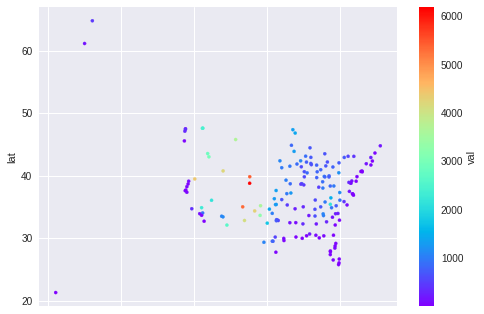

In [ ]:
airportLocDF = spark.sql("""SELECT FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',1))) AS lon,
                                    FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',-1))) AS lat,
                                    elevation_ft AS val
                        FROM airports 
                        WHERE type = 'large_airport' AND continent = 'NA' AND iso_country = 'US'""")

print('Plotting airport location - using altitude for different color')
airportLocPD = airportLocDF.toPandas()
airportLocPD.plot(x="lon",y="lat",c="val",s=10,cmap="rainbow",kind="scatter")


### Public holidays

Dates of public holidays in the US.

This dataset includes the following columns:

* Date: date (format: yyyy-mm-dd)
* Holiday: name of the holiday
* WeekDay: day of week
* Month: month (1-12)
* Day: day (1-31)
* Year: year (2002-2021)

Load the dataset into holidaysDF dataframe and register holidays under view name **holidays**.


In [ ]:
holidaysDF = spark.read.option("header", True).option("inferSchema",True).csv(HOLIDAYS_FILENAME)

holidaysDF.createOrReplaceTempView("holidays")

holidaysDF.show(3)


+----------+-----------+-------+-----+---+----+
|      Date|    Holiday|WeekDay|Month|Day|Year|
+----------+-----------+-------+-----+---+----+
|2004-07-04|4th of July| Sunday|    7|  4|2004|
|2005-07-04|4th of July| Monday|    7|  4|2005|
|2006-07-04|4th of July|Tuesday|    7|  4|2006|
+----------+-----------+-------+-----+---+----+
only showing top 3 rows



## Problem 0 [1 point]

We start by executing some simple statistics to compare the execution time between Spark and Pandas.


### Code: Spark

In [ ]:
start_time = time.time()

flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights_new")

result = spark.sql("SELECT OP_CARRIER, count(*) AS num_flights FROM flights_new GROUP BY OP_CARRIER")
result.show()

end_time = time.time()
print( "Runtime = " + str(end_time - start_time))



+----------+-----------+
|OP_CARRIER|num_flights|
+----------+-----------+
|        UA|     192622|
|        NK|      25439|
|        AA|     266003|
|        NW|      14128|
|        EV|     185522|
|        B6|      97885|
|        DL|     303978|
|        OO|     240809|
|        F9|      36190|
|        YV|      38181|
|        US|      84928|
|        MQ|     114668|
|        OH|      24677|
|        HA|      29920|
|        XE|      31772|
|        G4|       5123|
|        YX|      12706|
|        AS|      68912|
|        CO|      21141|
|        FL|      43105|
+----------+-----------+
only showing top 20 rows

Runtime = 6.624901533126831


* Execution time for sample.csv: 11.758420705795288 seconds
* Execution time for complete.csv: 170.09200310707092 seconds

Using GPU @ Colab (go to Execution time menu and change the type of execution time to include GPU):

* Execution time for sample.csv: 6.624901533126831 seconds
* Execution time for complete.csv: 9.488665342330933 seconds


### Code: Pandas library

In [ ]:
import pandas as pd
import time

start_time = time.time()
mySchema = {"FL_DATE": "str",
            "OP_CARRIER": "str",
            "OP_CARRIER_FL_NUM":"Int64",
            "ORIGIN":"str",
            "DEST":"str",
            "CRS_DEP_TIME":"str",
            "DEP_TIME":"str",
            "DEP_DELAY":"Int64",
            "TAXI_OUT":"Int64",
            "WHEELS_OFF":"str",
            "WHEELS_ON":"str",
            "TAXI_IN":"Int64",
            "CRS_ARR_TIME":"str",
            "ARR_TIME":"str",
            "ARR_DELAY":"Int64",
            "CANCELLED":"Int64",
            "CANCELLATION_CODE":"str",
            "DIVERTED":"Int64",
            "CRS_ELAPSED_TIME":"Int64",
            "ACTUAL_ELAPSED_TIME":"Int64",
            "AIR_TIME":"Int64",
            "DISTANCE":"Int64",
            "CARRIER_DELAY":"Int64",
            "WEATHER_DELAY":"Int64",
            "NAS_DELAY":"Int64",
            "SECURITY_DELAY":"Int64",
            "LATE_AIRCRAFT_DELAY":"Int64"
           }

dataframe = pd.read_csv(FLIGHTS_FILENAME,dtype=mySchema)
result = dataframe[["FL_DATE","OP_CARRIER"]].groupby("OP_CARRIER").count()
print(result)

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


* Execution time for sample.csv: Runtime = 22.397742986679077 seconds
* Execution time for complete.csv: Runtime => it crashed

**Discuss the results you have obtained:**

In the first part of the problem, using Spark, we can notice a difference between the runtime of the calculations made with the GPU (graphics processing unit) and the standard runtime (CPU - central processing unit).
The execution time for sample.csv using or not the GPU is pretty the same, but once processed the complete.csv the execution time of the standard runtime increases a lot, while the execution time of the GPU remains similar to the sample.csv one. This difference is due to the advanced calculation capacity of the GPU to accelerate the massive amount of data a CPU can only process in a given amount of time. In fact, the use of the GPUs is more convenient for repetitive and highly-parallel computing tasks.

When comparing the code execution time with the Pandas and Spark libraries, it turns out that the Pandas library is about three times slower than the Spark one. This is due to the size of the dataset we are working with. In fact, Pandas DataFrame performs better with small datasets, whereas, if you are working on a Machine Learning application where you are dealing with larger datasets, PySpark is a best fit which processes operations many times faster than Pandas.

When trying to run with Pandas the "complete.csv" dataframe it ended crashing the program, due to the big size of the file and the incapacity of Pandas to deal with a large number of information.


## Problem 1 [4 points]

In this first problem, you should compute a set of statistics on the data.


### **For now on we use the "data_2018.csv" file, due to the difficulties we faced trying to run the "complete.csv".**

### Top-20 airports with more flights (include the name of the airport)

In [ ]:
top_20_airports = spark.sql("""SELECT * FROM flights f LEFT JOIN airports a
                                ON a.iata_code = f.ORIGIN""").createOrReplaceTempView("top20A")

spark.sql("""SELECT ORIGIN, DEST, name, iata_code
                    FROM top20A""").createOrReplaceTempView("top20B")
spark.sql("""SELECT name, COUNT(ORIGIN) AS cntO, ORIGIN FROM top20B GROUP BY ORIGIN, name""").createOrReplaceTempView("top20C")
spark.sql("""SELECT COUNT(DEST) AS cntD, DEST FROM top20B GROUP BY DEST""").createOrReplaceTempView("top20D")
spark.sql("""SELECT * FROM top20C c JOIN top20D d ON c.ORIGIN=d.DEST""").createOrReplaceTempView("top20E")

sum=spark.sql("""SELECT  name as AirportName, ORIGIN as IATAcode, cntO+cntD AS NumberOfFlights
                  FROM top20E
                  ORDER BY NumberOfFlights DESC
                  LIMIT 20""").toPandas()
sum.index=sum.index+1
sum


,AirportName,IATAcode,NumberOfFlights
1,Hartsfield Jackson Atlanta International Airport,ATL,780125
2,Chicago O'Hare International Airport,ORD,665895
3,Dallas Fort Worth International Airport,DFW,558570
4,Denver International Airport,DEN,472009
5,Charlotte Douglas International Airport,CLT,466626
6,Los Angeles International Airport,LAX,443002
7,San Francisco International Airport,SFO,351788
8,Phoenix Sky Harbor International Airport,PHX,347915
9,George Bush Intercontinental Houston Airport,IAH,347588
10,La Guardia Airport,LGA,342175


### Top-20 days with more flights

In [ ]:
top20F=spark.sql("""SELECT FL_DATE as FlightDate, COUNT(FL_DATE) AS NumberOfFlights from flights
          GROUP BY FlightDate
          ORDER BY NumberOFFlights DESC
          LIMIT 20""").toPandas()
top20F.index=top20F.index+1
top20F

,FlightDate,NumberOfFlights
1,2018-11-25,22160
2,2018-07-13,22022
3,2018-07-20,22002
4,2018-07-27,21997
5,2018-08-03,21990
6,2018-07-12,21966
7,2018-07-16,21958
8,2018-07-09,21956
9,2018-07-23,21955
10,2018-07-30,21952


### Periods with more flights: morning (00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)

In [ ]:
flights=flightsDF.withColumnRenamed("OP_CARRIER_FL_NUM","FlightNumber")\
                                    .withColumnRenamed("DEP_TIME","DepartureTime")\
                                    .withColumnRenamed("ARR_TIME","ArrivalTime")

flights1=flights.select("FlightNumber", "DepartureTime", "ArrivalTime")
morning=flights1.filter("DepartureTime between '00:00' and '11:59' or ArrivalTime between '00:00' and '11:59' ").count()
midday=flights1.filter("DepartureTime between '12:00' and '17:59' or ArrivalTime between '12:00' and '17:59' ").count()
evening=flights1.filter("DepartureTime between '18:00' and '23:59' or ArrivalTime between '18:00' and '23:59' ").count()
periods = {'Periods': ['Morning', 'Midday', 'Evening'], 'Number of Flights': [morning, midday, evening]}
pd.DataFrame(periods).sort_values(by=["Number of Flights"], ascending=False)

#the calculation of the flights for each period was made considering the period of arrival and the period of departure.
#if the flight departed and arrived in two different periods, it is counted twice (once for each period)
#while if the flight departed and arrived in the same period, it is counted only once.


,Periods,Number of Flights
1,Midday,3431463
0,Morning,3231567
2,Evening,2599931


### Top-20 airports with longer delays

In [ ]:
top_20_airports = spark.sql("""SELECT * FROM flights f LEFT JOIN airports a
                                ON a.iata_code = f.ORIGIN""").createOrReplaceTempView("top20A")

top20D=spark.sql("""SELECT name as AirportName, BROUND(MEAN(DEP_DELAY),2) AS Delay FROM top20A
              WHERE DEP_DELAY>0
              GROUP BY name
              ORDER BY Delay DESC
              LIMIT 20""").toPandas()
top20D.index=top20D.index+1
top20D


,AirportName,Delay
1,Devils Lake Regional Airport,138.42
2,Pago Pago International Airport,106.45
3,Jamestown Regional Airport,104.86
4,Houghton County Memorial Airport,99.82
5,Rhinelander Oneida County Airport,96.75
6,Greenbrier Valley Airport,95.56
7,Salina Municipal Airport,94.35
8,Shenandoah Valley Regional Airport,89.89
9,North Central West Virginia Airport,88.91
10,Ithaca Tompkins Regional Airport,88.40


### Top 10 carriers with longer delays

In [ ]:
top10C=spark.sql("""SELECT OP_CARRIER as Carriers, BROUND(MEAN(DEP_DELAY),2) AS Delay FROM flights
              WHERE DEP_DELAY>0
              GROUP BY OP_CARRIER
              ORDER BY Delay DESC
              LIMIT 10""").toPandas()
top10C.index=top10C.index+1
top10C


,Carriers,Delay
1,EV,61.87
2,OO,54.69
3,9E,53.95
4,YV,51.56
5,F9,50.86
6,G4,49.59
7,B6,47.01
8,YX,46.78
9,NK,46.66
10,UA,45.34


### Longer delays by period: morning (00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)


In [ ]:
flights=flightsDF.withColumnRenamed("OP_CARRIER_FL_NUM","FlightNumber")\
                  .withColumnRenamed("DEP_TIME","DepartureTime")\
                  .withColumnRenamed("ARR_TIME","ArrivalTime")\
                  .withColumnRenamed("DEP_DELAY","DepartureDelay")

flights1=flights.select("FlightNumber", "DepartureTime", "ArrivalTime", "DepartureDelay")
flights1 = flights1.withColumn('Periods',lit(flights1.filter("DepartureTime between '00:00' and '11:59' and ArrivalTime between '00:00' and '11:59'")=='morning'))

morning=flights1.filter("DepartureTime between '00:00' and '11:59' or ArrivalTime between '00:00' and '11:59' ").where(flights1.DepartureDelay>=0).select(bround(mean("DepartureDelay"),2)).collect()[0][0]
midday=flights1.filter("DepartureTime between '12:00' and '17:59' or ArrivalTime between '12:00' and '17:59' ").where(flights1.DepartureDelay>=0).select(bround(mean("DepartureDelay"),2)).collect()[0][0]
evening=flights1.filter("DepartureTime between '18:00' and '23:59' or ArrivalTime between '18:00' and '23:59' ").where(flights1.DepartureDelay>=0).select(bround(mean("DepartureDelay"),2)).collect()[0][0]

delaysPeriods = {'Periods': ['Morning', 'Midday', 'Evening'], 'AverageDelay': [morning, midday, evening]}
pd.DataFrame(delaysPeriods)


,Periods,AverageDelay
0,Morning,32.46
1,Midday,29.07
2,Evening,40.27


## Problem 2 [4 points]

Assume you want to create a web site to help travellers get information about flight delays. The web site would allow a user to find out information about delays for the flight she want to take. 
The information about delays should include at least 3 statistics - suggestion: the average delay in the same route of the same carrier in the last 7 days, 30 days, 365 days, similar but considering only flights in the same week day, similar but considering flights in the same week day, but excluding holidays, etc.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user.

Write the code to build these indices - for each index, print 5 lines.

In [ ]:
from pyspark.sql.functions import udf,desc
from datetime import datetime
from pyspark.sql.functions import date_format

flightsDF1 = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)
flightsDF1.createOrReplaceTempView("flights")
flightsDF1.show(3)


#Holiday + Flights dataset
df1 = spark.sql("""SELECT * 
                      FROM flights f
                      LEFT JOIN holidays h on h.Date = f.FL_DATE
                      """)
WeekDay =  udf(lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%w'))
DayCategory=udf(lambda x: 'Weekend' if int(x) > 5 else 'Weekday' )
Holiday =  udf(lambda x,y: y if x is None else 'Holiday')

df1 = df1.withColumn('WeekDay', WeekDay(df1['FL_DATE']))
df1 = df1.withColumn('DayCategory', DayCategory(df1['WeekDay']))
df1 = df1.withColumn('DayCategory', Holiday(df1['Holiday'],df1['DayCategory']))
df1.createOrReplaceTempView("complete")

#COMPUTE DELAYS STATISTICS 
delay_7day = spark.sql("""SELECT ORIGIN, DEST, OP_CARRIER, ROUND(AVG(ARR_DELAY),2) as WeeklyDelay 
                          FROM (SELECT * FROM flights WHERE CANCELLED = 0 AND  FL_DATE+7 > '2018-07-15') d 
                          GROUP BY ORIGIN, DEST, OP_CARRIER 
                          ORDER BY WeeklyDelay DESC""")
delay_7day.createOrReplaceTempView("partial_7")
delay_7day.show(5)

delay_30day = spark.sql("""SELECT ORIGIN, DEST, OP_CARRIER, ROUND(AVG(ARR_DELAY),2 ) as MonthlyDelay
                            FROM (SELECT * FROM flights WHERE CANCELLED = 0 AND  FL_DATE+30 > '2018-07-15') d 
                            GROUP BY ORIGIN, DEST, OP_CARRIER 
                            ORDER BY MonthlyDelay DESC
                            """)
delay_30day.createOrReplaceTempView("partial_30")
delay_30day.show(5)

delay_365day = spark.sql("""SELECT ORIGIN, DEST, OP_CARRIER, ROUND(AVG(ARR_DELAY),2 ) as AnnualDelay
                            FROM (SELECT * FROM flights WHERE CANCELLED = 0 AND  FL_DATE+365 > '2018-07-15') d 
                            GROUP BY ORIGIN, DEST, OP_CARRIER 
                            ORDER BY AnnualDelay DESC
                            """)
delay_365day.createOrReplaceTempView("partial_365")
delay_365day.show(5)

delay_carrier = spark.sql("""SELECT ORIGIN, DEST, OP_CARRIER, ROUND(AVG(ARR_DELAY),2 ) as CarrierDelay, DayCategory
                             FROM (SELECT * FROM complete WHERE CANCELLED = 0) d 
                             GROUP BY ORIGIN, DEST, OP_CARRIER, DayCategory""")
delay_carrier.createOrReplaceTempView("partial_carrier")
delay_carrier.show(5)

#Create a DataFrame with all the info/indices about delays
finalDF = spark.sql("""SELECT a.ORIGIN as OriginAirport, a.DEST as DestinationAirport, a.OP_CARRIER as CarrierCode, DayCategory, WeeklyDelay, MonthlyDelay, AnnualDelay, CarrierDelay
                   FROM partial_7 a 
                   LEFT JOIN partial_30 b 
                   ON a.ORIGIN = b.ORIGIN 
                   AND a.DEST = b.DEST 
                   AND a.OP_CARRIER = b.OP_CARRIER
                   LEFT JOIN partial_365 c 
                   ON a.ORIGIN = c.ORIGIN 
                   AND a.DEST = c.DEST 
                   AND a.OP_CARRIER = c.OP_CARRIER
                   LEFT JOIN partial_carrier d 
                   ON a.ORIGIN = d.ORIGIN 
                   AND a.DEST = d.DEST 
                   AND a.OP_CARRIER = d.OP_CARRIER
                   ORDER BY CarrierDelay DESC""")
finalDF.show(5)
finalDF.createOrReplaceTempView("answer")

print("\nInfoPoint: Flight Delays")
carrier= input("Please insert the carrier code you want information about(e.g. XE): ")
or_airport = input("Please insert the Iata code of the Origin Airport (e.g. DCE): ").upper()
de_airport = input("Please insert the Iata code of the Destination Airport (e.g. EWR): ").upper()

user_queries = f"""SELECT * FROM answer f 
            WHERE "{carrier}" = f.CarrierCode 
            AND "{or_airport}" = f.OriginAirport 
            AND "{de_airport}" = f.DestinationAirport 
            ORDER BY CarrierDelay DESC"""

final_answer = spark.sql(user_queries)
final_answer.show(5)

if len(final_answer.head(1)) > 0: 
  best_carrier = final_answer.first().CarrierCode
  day_category =final_answer.first().DayCategory 
  print(f'The best option to travel is with {best_carrier}, on a {DayCategory} !') 
else:
  print('No information found. Try to put another connection')            

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2018-01-01|        UA|             2

#### Discussion

Firstly,  before computing the several statistics about delays, we created the complete dataframe following these steps: 
1. We merged the general dataframe "flights" with the "holidays" dataframe on the respective Date variables in order to include all the useful information.

2. We created additional columns to classify the date in Weekday/Weekend, Holiday/Non-holiday, Week-day (Monday, Tuesday etc.) and we added them to the general dataframe.

3. We computed 4 statistics to measure average arrival delay. We used ARR_DELAY since this measure is more useful to the user compared to DEP_DELAY. The specific code for those statistics doesn't consider cancelled flights and eeach average value is computed over a window of 7/30/365 days or based on Carrier. For the average in windows, we used the last date of the dataframe. 

4. At the end we merged all the information in the Final Dataframe (finalDF) in ascending order of delays. 

5. Focusing on the interaction side, we created user queries for the main variables, explained below. Then we created an ad-hoc dataframe for the user queries.

The user will have to ask for the origin and destination airport, which carrier she/he wants to leave with. This code has been run with the 2018 year dataset.

## Problem 3 [4 points]

Transform the flights data to include a class, depending on the delay - SHORT, LONG - depending on whether the departure delay was less than 10 minutes, or greater or equal to 10 minutes.

Build and evaluate a classification model for the data.


In [ ]:
from pyspark.sql import functions as f

a=flightsDF.withColumn('ClassDelay', f.when(f.col('DEP_DELAY') >= 10, "Long").otherwise("Short"))

a = a.select(['ClassDelay', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DISTANCE'])

from pyspark.ml.feature import StringIndexer
categorical_variables=['OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'ClassDelay']
for variable in categorical_variables:
    indexer = StringIndexer(inputCol=variable, outputCol=variable+"index")
    a = indexer.fit(a).transform(a)
a=a.drop('ClassDelay', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME')

a=a.na.drop()
a.printSchema()
a.show()

root
 |-- DISTANCE: integer (nullable = true)
 |-- OP_CARRIERindex: double (nullable = false)
 |-- ORIGINindex: double (nullable = false)
 |-- DESTindex: double (nullable = false)
 |-- CRS_DEP_TIMEindex: double (nullable = false)
 |-- CRS_ARR_TIMEindex: double (nullable = false)
 |-- ClassDelayindex: double (nullable = false)

+--------+---------------+-----------+---------+-----------------+-----------------+---------------+
|DISTANCE|OP_CARRIERindex|ORIGINindex|DESTindex|CRS_DEP_TIMEindex|CRS_ARR_TIMEindex|ClassDelayindex|
+--------+---------------+-----------+---------+-----------------+-----------------+---------------+
|    1605|            4.0|       14.0|      3.0|            395.0|             90.0|            0.0|
|     414|            4.0|       10.0|      6.0|             47.0|            410.0|            0.0|
|     846|            4.0|       46.0|      3.0|            140.0|            220.0|            0.0|
|    1120|            4.0|       49.0|      1.0|            629.0

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

numerical_variables=a.select(['OP_CARRIERindex', 'ORIGINindex', 'DESTindex', 'CRS_DEP_TIMEindex', 'CRS_ARR_TIMEindex','DISTANCE'])
encoder = OneHotEncoder(inputCol='OP_CARRIERindex', outputCol='OP_CARRIERnorm')
encoder = encoder.fit(a)
a = encoder.transform(a) 

encoder = OneHotEncoder(inputCol='ORIGINindex', outputCol='ORIGINnorm')
encoder = encoder.fit(a)
a = encoder.transform(a)

encoder = OneHotEncoder(inputCol='DESTindex', outputCol='DESTnorm')
encoder = encoder.fit(a)
a = encoder.transform(a)

encoder = OneHotEncoder(inputCol='CRS_DEP_TIMEindex', outputCol='CRS_DEP_TIMEnorm')
encoder = encoder.fit(a)
a = encoder.transform(a)

encoder = OneHotEncoder(inputCol='CRS_ARR_TIMEindex', outputCol='CRS_ARR_TIMEnorm')
encoder = encoder.fit(a)
a = encoder.transform(a)

encoder = OneHotEncoder(inputCol='DISTANCE', outputCol='DISTANCEnorm')
encoder = encoder.fit(a)
a = encoder.transform(a)

a=a.drop('OP_CARRIERindex', 'ORIGINindex', 'DESTindex', 'CRS_DEP_TIMEindex', 'CRS_ARR_TIMEindex','DISTANCE')


In [ ]:
# Vector Assembler
from pyspark.ml.feature import VectorAssembler

cols = a.select(['OP_CARRIERnorm', 'ORIGINnorm', 'DESTnorm', 'CRS_DEP_TIMEnorm', 'CRS_ARR_TIMEnorm','DISTANCEnorm']).columns
assembler=VectorAssembler(inputCols=cols,outputCol='feature_vector')
a=assembler.transform(a).select('ClassDelayindex','feature_vector')
a.take(1)
a.show()



+---------------+--------------------+
|ClassDelayindex|      feature_vector|
+---------------+--------------------+
|            0.0|(8512,[4,31,377,1...|
|            0.0|(8512,[4,27,380,7...|
|            0.0|(8512,[4,63,377,8...|
|            0.0|(8512,[4,66,375,1...|
|            1.0|(8512,[4,18,463,7...|
|            0.0|(8512,[4,18,430,1...|
|            0.0|(8512,[4,25,384,8...|
|            0.0|(8512,[4,20,477,1...|
|            1.0|(8512,[4,61,388,1...|
|            0.0|(8512,[4,78,377,1...|
|            0.0|(8512,[4,49,388,9...|
|            1.0|(8512,[4,18,417,9...|
|            0.0|(8512,[4,31,406,7...|
|            1.0|(8512,[4,31,374,1...|
|            1.0|(8512,[4,18,474,1...|
|            1.0|(8512,[4,33,379,1...|
|            1.0|(8512,[4,31,418,9...|
|            1.0|(8512,[4,66,388,8...|
|            0.0|(8512,[4,25,527,7...|
|            0.0|(8512,[4,93,388,1...|
+---------------+--------------------+
only showing top 20 rows



In [ ]:
#split data into train and test set

ratio = 0.7
train = a.sampleBy('ClassDelayindex',fractions={0:ratio,1:ratio}, seed = 42)
test = a.subtract(train)

In [ ]:
#Model selection

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'feature_vector', labelCol = 'ClassDelayindex', maxIter=10)
lrModel = lr.fit(train)

In [ ]:
#Generating predictions
predictions = lrModel.transform(train)
predictions.select(['ClassDelayindex','prediction', 'probability']).show()

+---------------+----------+--------------------+
|ClassDelayindex|prediction|         probability|
+---------------+----------+--------------------+
|            0.0|       0.0|[0.69044980312274...|
|            0.0|       0.0|[0.78350900307366...|
|            0.0|       0.0|[0.83265189916365...|
|            1.0|       0.0|[0.89252144167173...|
|            0.0|       0.0|[0.83818750047416...|
|            0.0|       0.0|[0.81504968528592...|
|            0.0|       0.0|[0.84658058071577...|
|            1.0|       0.0|[0.70128664280955...|
|            0.0|       0.0|[0.90613155476103...|
|            1.0|       0.0|[0.64800345668840...|
|            1.0|       0.0|[0.71942016700270...|
|            0.0|       0.0|[0.88146972413261...|
|            1.0|       0.0|[0.86476857864294...|
|            0.0|       0.0|[0.85346302263703...|
|            0.0|       0.0|[0.65744303949975...|
|            0.0|       0.0|[0.69215302087639...|
|            1.0|       0.0|[0.67884095063244...|


In [ ]:
y_true = predictions.select(['ClassDelayindex']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88   3948861
         1.0       0.54      0.02      0.04   1100439

    accuracy                           0.78   5049300
   macro avg       0.66      0.51      0.46   5049300
weighted avg       0.73      0.78      0.69   5049300

[[3931670   17191]
 [1080346   20093]]


#### Discussion

**Explain your code and discuss results**

**EXPLANATION OF THE CODE**:

In order to build a classification model based on the classes "long" and "short" referring to the departure delay of 10 minutes or less, I followed the following steps: 

1.   First of all I added the column "ClassDelay" containing the classification of the delay as long or short.
2.   After that, I selected from the dataset flightsDF what I thought could be the columns related to the prediction of the class of delay: OP_CARRIER, ORIGIN, DEST, CRS_DEP_TIME, CRS_ARR_TIME, DISTANCE, that are the carrier operator, the iata code of the departure airport and the arrival one, the scheduled local arrival and departure time and the flight distance (in miles). 
3. I converted the values of the categorical variables into integers, so that I could place them inside a vector and build the classification model.
4. I then converted that variables into one-hot numeric array. This encoding allows algorithms which expect continuous features, such as Logistic Regression, to use categorical features. 
5. I assembled the vectors obtained by *onehotencoder* into a sigle feature  and transformed the DataFrame into a two columns DataFrame that only contained the feature_vector and the ClassDelayindex.
6. I then divided the data into train and test set.
7. I applied the logistic regression model to the train set.
8. To evaluate the model I generated the predictions and built the confusion matrix.

**RESULTS**: The precision of our model, that is the percentage of the predicted "short" values that are actually "short", is higher respect to the precision of the "long" values. This means that our model has some difficulties to identify the flights that actually had a long delay.

Recall, that show us the capacity of the classifier to predict the positive samples, is equal to 1 for the short delays, which means that all the delays predicted as short are actually short. While for the longest one is equal to 0, that means that there were not true positives.

F1 is the harmonic mean of precision and recall, indeed it takes both false positive and false negatives into account, and as the other evaluation measures it warns us that our model is not appropriate to classify the delay into the classes "short" and "long". The higher number of "short" values make the model seems more appropriate, but the low percentage of the evaluation measures shows a clear problem in identifying the "long" class of delays.

This means that the variables we used for our model are not the best appropriate to find discriminant between the two classes. 

Other variables, such as the ones related to the holidays, would be more appropriate to predict the delay of the flights, but it hasn't been possible to build the model with a larger dataset, because the program didn't work properly. 

## Problem 4 [4 points]

Consider we want to cluster airports depending on their properties, such as average number of flights per day, delays, cancellations, etc.

Measure the quality of your clustering result.

+--------+------------------+-----------+--------------------+--------------------+-----------+-----------+
|IataCode|     NrFlightsxday|AvgDepDelay|       PercCancelled|        PercDiverted|AvgDuration|AvgDistance|
+--------+------------------+-----------+--------------------+--------------------+-----------+-----------+
|     ABE|11.832335329341317|       5.82| 0.02032721864154685|0.001983143282102...|      92.16|     561.74|
|     ABI| 7.281437125748503|       8.67|0.023293172690763052|0.001606425702811245|      33.74|      158.0|
|     ABQ|105.96706586826348|       5.04|0.005311674442133663|0.001967286830419875|      90.51|     641.72|
|     ABY| 2.933734939759036|       7.75|0.021105527638190954|0.001005025125628...|       35.7|      146.0|
|     ACK|3.0555555555555554|      16.48| 0.03508771929824561|                 0.0|      44.43|      199.0|
+--------+------------------+-----------+--------------------+--------------------+-----------+-----------+
only showing top 5 rows

The

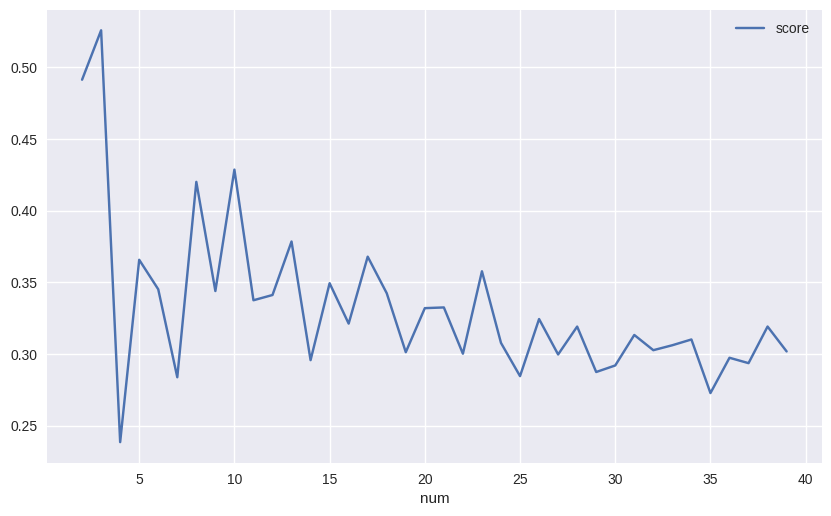

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
from sklearn import preprocessing

#CREATE DATAFRAME

#flightsDF.createOrReplaceTempView("flights")

#1. Avg number of flights per day in each airport 
avgNrFlights_1= spark.sql("""SELECT ORIGIN as IataCode, COUNT(ORIGIN)/COUNT(DISTINCT(FL_DATE)) as NrFlightsxday 
                          FROM (SELECT * FROM flights WHERE CANCELLED = 0)  
                          GROUP BY IataCode
                          ORDER BY NrFlightsxday
                          """)
avgNrFlights_1.createOrReplaceTempView("var1")

#2. Avg minutes of departure delay in each airport
avgDepDelay_1 = spark.sql("""SELECT ORIGIN as IataCode, ROUND(AVG(DEP_DELAY),2) as AvgDepDelay
                            FROM (SELECT * FROM flights WHERE CANCELLED = 0)  
                            GROUP BY IataCode
                            ORDER BY AvgDepDelay
                            """)
avgDepDelay_1.createOrReplaceTempView("var2") 

#3. Cancellation flights frequency in each airport
cancfrequency_1 = spark.sql("""SELECT ORIGIN as IataCode, AVG(CANCELLED) as PercCancelled
                            FROM flights  
                            GROUP BY IataCode
                            ORDER BY PercCancelled
                            """)
cancfrequency_1.createOrReplaceTempView("var3")

#3. Diverted flights frequency in each airport
cancfrequency_1 = spark.sql("""SELECT ORIGIN as IataCode, AVG(DIVERTED) as PercDiverted
                            FROM flights  
                            GROUP BY IataCode
                            ORDER BY PercDiverted
                            """)
cancfrequency_1.createOrReplaceTempView("var4")

#4. Average flight Duration in each airport
avgDuration_1 = spark.sql("""SELECT ORIGIN as IataCode, ROUND(AVG(AIR_TIME),2) as AvgDuration
                            FROM (SELECT * FROM flights WHERE CANCELLED = 0)  
                            GROUP BY IataCode
                            ORDER BY AvgDuration
                            """)
avgDuration_1.createOrReplaceTempView("var5")

#5. Average Flight Distance in each airport  bc of intercontinental flights
avgDistance_1 = spark.sql("""SELECT ORIGIN as IataCode, ROUND(AVG(DISTANCE),2) as AvgDistance
                            FROM (SELECT * FROM flights WHERE CANCELLED = 0)  
                            GROUP BY IataCode
                            ORDER BY AvgDistance
                            """)
avgDistance_1.createOrReplaceTempView("var6")

#Create Clusters DataFrame
finalDF_clusters = spark.sql("""SELECT a.IataCode, NrFlightsxday, AvgDepDelay, PercCancelled, PercDiverted, AvgDuration, AvgDistance  
                   FROM var1 a 
                   LEFT JOIN  var2 b 
                   ON a.IataCode = b.IataCode 
                   LEFT JOIN var3 c 
                   ON a.IataCode = c.IataCode
                   LEFT JOIN var4 d 
                   ON a.IataCode = d.IataCode 
                   LEFT JOIN var5 e 
                   ON a.IataCode = e.IataCode
                   LEFT JOIN var6 f 
                   ON a.IataCode = f.IataCode
                   ORDER BY IataCode""")

finalDF_clusters.show(5)
finalDF_clusters.createOrReplaceTempView("answer")

#NORMALIZE VALUES IN COLUMNS
clusterDF_norm=finalDF_clusters.toPandas()
clusterDF_norm.iloc[:,1:] = clusterDF_norm.iloc[:,1:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
clusterDF_norm.head(5)
dataset = spark.createDataFrame(clusterDF_norm)

#FEATURES combination
input_list = [item for item in clusterDF_norm]
assembler = VectorAssembler(inputCols = input_list[1:],outputCol = "features")
dataset1 = assembler.transform(dataset)

#SILHOUETTE ANALYSIS:
def evaluate(input, k):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(input)
    predictions = model.transform(input)
    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    return score

df = pd.DataFrame(columns=['num','score'])
for i in range(2,40):
  df = df.append({"num": i, "score": evaluate(dataset1,i)}, ignore_index=True)

  df = pd.DataFrame(columns=['num','score'])
for i in range(2,40):
    df = df.append({"num": i, "score": evaluate(dataset1,i)}, ignore_index=True)

# PLOT SCORE   
df.plot( x="num", y="score")
k= int(df.nlargest(1,"score")["num"].values[0])
v= float(df.nlargest(1,"score")["score"])
print(f"The best result is reached with {k} clusters and a related quality of {v}")

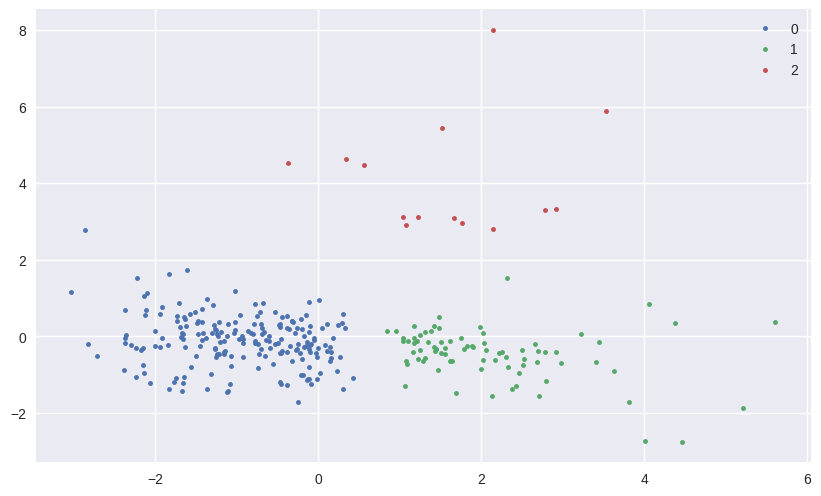

In [ ]:
kmeans=KMeans().setK(k).setSeed(1)
model= kmeans.fit(dataset1)
predictions=model.transform(dataset1)
predictions = predictions.drop('features')
predictionsPD = predictions.toPandas()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

clusters_pca = predictionsPD.iloc[:, 2:].values 
clusters_pca = StandardScaler().fit_transform(clusters_pca)

pc = PCA(n_components=k)
reduced = pc.fit_transform(clusters_pca)

#DISPLAY RESULTS WITH PCA
for row in predictionsPD['prediction'].unique(): 
    mask = predictionsPD['prediction'] == row
    plt.plot(reduced[mask, 0], reduced[mask, 1], '.',label=row)
plt.legend()

#### Discussion
In order to cluster airports, we chose to aggregate airports following these variables:
1. Average number of flights per day for each report.
2. Average departure delay for each airport in minuts. We didn't drop negative values for DEP_DELAY because in our opinion it is reasonable to cluster airport for the average performance. 
3. Percentage of Cancelled Flights per airport. This is the frequency of cancelled flight per airport and it might deliver some interesting insights on aiport clusters. 
4. Percentage of Diverted Flights per airport. This is the frequency of diverted flight for each airport.
5. Average duration of flights leaving from each airport. This variable can be interesting to see if there are clusters with longer average of duration (e.g. intercontinental flights mostly leaving from there, or local airport which mostly do national flights).
5. Average distance. Strictly correlated to the one above for the same reasons. Not surprisingly, if we compute the correlation between variable 6 and 5 is strictly positive and high.

The final dataframe created considers all the variables as normalized. This is because, since we use distance-based measurement, for clusters it's better to have zero-mean distribution and a stdv equal to one. 

We used Kmeans and the Silhouette Score to assign each element to the related cluster. The score measures the quality of the model and therefore how close the element is to its cluster compared to other clusters. 
The quality of this model is equal to almost 53% which means our cluster are not very dense or clearly distinct, but the model has not a bad performance. The clusters are 3 and with pca they are almost defined.   

Thanks to iteration, we have computed the clustering for different values of K, leading to the conclusion that k=3 is the optimal number with the highest quality score.

All in all, the score is not low. There is margin for improvement, maybe by choosing other variables. Cancellation rate, and also average delay are variables with mostly low values due to their nature. This can affect the model. 

This code has been run with 2009 dataset and not with the 2018 since in the first case way it delivers a better output. The performance of the 2018 dataset was not good because even with a quality of 71% it recognized only 2 clusters, a dense one and a non-dense second one. By changing the variables analyzed, the result could have been more insightful. 

## Problem 5 [3 points]

We now want to find communities of airports, i.e., airports that are connected based on the flights that exist.

Propose an algorithm to solve this problem and plot the communities as a graph. Run the program with and without GPU support.

In [ ]:
edges = spark.sql("""WITH totedges AS (SELECT origin AS src,
                                              dest AS dst,
                                              COUNT(*) AS cnt
                                              FROM flights
                                              GROUP BY src, dst),
                          airp_dep AS (SELECT origin AS src,
                                              COUNT(*) AS src_cnt
                                              FROM flights
                                              GROUP BY src),
                          airp_arr AS (SELECT dest AS dst,
                                              COUNT(*) AS dst_cnt
                                              FROM flights
                                              GROUP BY dst)
                      SELECT e.src, e.dst, e.cnt
                      FROM totedges e
                      LEFT JOIN airp_dep d ON e.src = d.src
                      LEFT JOIN airp_arr a ON e.dst = a.dst
                      WHERE e.cnt/d.src_cnt > 0.05 OR e.cnt/a.dst_cnt > 0.05""")
edges.createOrReplaceTempView("edges")
edges.show(4)

+---+---+---+
|src|dst|cnt|
+---+---+---+
|DTW|BGM|920|
|ANC|DLG| 84|
|MSP|INL|650|
|MCO|PSE|448|
+---+---+---+
only showing top 4 rows



In [ ]:
vertices = spark.sql("""SELECT f.id,
                               FLOAT(TRIM(SUBSTRING_INDEX(a.coordinates,',',1))) AS lon,
                               FLOAT(TRIM(SUBSTRING_INDEX(a.coordinates,',',-1))) AS lat
                        FROM (SELECT src AS id FROM edges
                              UNION 
                              SELECT dst AS id FROM edges) f
                        JOIN airports a ON f.id = a.iata_code""")
vertices.createOrReplaceTempView("vertices")
vertices.show(4)

+---+--------+-------+
| id|     lon|    lat|
+---+--------+-------+
|BGM|-75.9798|42.2087|
|INL|-93.4031|48.5662|
|PSE| -66.563|18.0083|
|DLG|-158.505|59.0447|
+---+--------+-------+
only showing top 4 rows



In [ ]:
from graphframes import *
g = GraphFrame(vertices, edges)
result = g.labelPropagation(maxIter=5)
result.select("id", "label").show()

+---+-------------+
| id|        label|
+---+-------------+
|BTM| 661424963585|
|OGS|1013612281856|
|ATW|1056561954817|
|ALO|1056561954817|
|HTS|1013612281856|
|YAK|1047972020225|
|DLG|1649267441664|
|SNA| 661424963585|
|BOS| 893353197569|
|IMT|1056561954817|
|MIA| 970662608897|
|BWI| 970662608897|
|ABI|1056561954817|
|SCE|1056561954817|
|BGM|1056561954817|
|GTR|1056561954817|
|UIN| 936302870528|
|AKN|1649267441664|
|FAT| 661424963585|
|YUM| 661424963585|
+---+-------------+
only showing top 20 rows



In [ ]:
communitiesDF = result.toPandas()

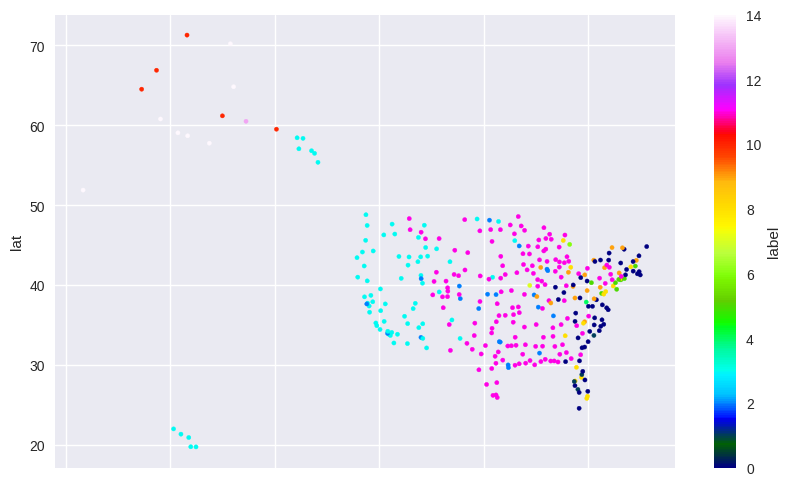

In [ ]:
import matplotlib.pyplot as plt
communitiesDFplot = communitiesDF.copy()
communitiesDFplot['label'] = communitiesDFplot['label'].astype('category').cat.codes

airports_df = airportsDF.toPandas()
communitiesDFplot = communitiesDFplot.merge(airports_df[['iata_code', 'iso_country', 'continent']], left_on='id', right_on='iata_code')
communitiesDFplot = communitiesDFplot[(communitiesDFplot['iso_country'] == 'US') & (communitiesDFplot['continent'] == 'NA')]
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
cmap = 'Set1' if len(communitiesDFplot['label'].unique()) <= 9 else 'gist_ncar'
communitiesDFplot.plot.scatter(x="lon",y="lat",c="label",s=9,cmap=cmap)

#### Explain your code and discuss results

In order to find the communities of airports based on the flights that exists we have followed the following steps:
we have created a Dataframe with Spark including the source airport, the destination one and the number of connections (flights) between the two, but only the connections greater than the 5% of the total ones for that airport.
we then defined the vertices, that are the location of the airports, measured through longitude and latitude.
Through GraphFrame we defined the communities of airport, assigning to the airport of the same community the same random number.
-we converted our DataFrame into Pandas in order to plot our result.
For the plot, we only considered the communities of airports in the USA.

The resulting plot shows a big community (the yellow one) in the east of the country, and some other smaller ones in the same area (purple, green and red). In the middle of USA we found another consistent community of airports, while the ones in the northern-west part of the country (the orange and grey one) are smaller.

The execution of the problem without the use of the GPU takes 50% longer.